In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import os
from tinygp import kernels, GaussianProcess
import jax
from jax.scipy import linalg
import jax.numpy as jnp
import optax
from tqdm.notebook import trange, tqdm
from tinygp.noise import Diagonal
from tqdm import notebook
jax.config.update("jax_enable_x64", True)
plt.style.use(['science', 'no-latex', 'notebook', 'grid'])
import pickle
import pandas as pd
from CARPoolGP import *

In [2]:
class Test:
    def __init__(self, params, Qs, lb, ub):
        
        self.params = np.array([params])
        self.Qs     = Qs
        self.var = np.var(Qs, axis=-1)
        self.tests = np.linspace(lb, ub, 100)


    def mean(self):
        return np.mean(self.Qs)
         
class Surrogates:
    def __init__(self, params, Qs, N=11, param_indices=[5]):
        
        
        self.param_indices = param_indices
        if len(param_indices)==1:
            self.params = np.repeat(params, N)
            self.Qs     = np.repeat(Qs, N).reshape(len(Qs.T), N).T
            self.var = Qs.var(axis=-1)
            self.E = np.ones(N-1-1)*self.var
            self.mean = Qs.mean(axis=-1)*np.ones(N-1-1)
        else:
            self.Qs, self.params     = self.sort_Qs(Qs, params) 
            
        
        
    def match_ICs(self, param_indices, halo_indices):
        """
        We want to match the ICs for the HR sims that have some set of indices
        """ 
        surrogates =[]
        for hi, pi in zip(halo_indices, param_indices):
            surrogates.append(self.Qs[pi, hi])
            
        self.surrogates = np.array(surrogates)
        self.params = self.params[param_indices]
        
        if len(self.param_indices) >1:
            self.var = self.var[param_indices]
            self.mean = self.mean[param_indices]
            self.E = self.var#/((11-1-len(self.param_indices))/2)#np.sqrt(self.var) * np.ones_like(self.params)
        
        

        
    def sort_Qs(self, Qs, params):
        # Find the closest params (knearest neighbors)
        args = np.arange(11)
        N_per_group = (len(args)-1-len(self.param_indices))/len(self.param_indices)
        gs = []
        for i, a in enumerate(self.param_indices):
            bound = int(N_per_group/len(self.param_indices))+1
            if i==0:
                # For the first arg always include it in the group
                gs.append(args[:a+bound])
            elif i==len(self.param_indices)-1:
                gs.append(args[self.param_indices[i-1]+bound-1:])
            else:
                gs.append(args[self.param_indices[i-1]+bound-1:a+bound])
        new_Qs = np.zeros((len(args), len(Qs.T)))
        new_params = np.zeros(len(args))
        for i,g in enumerate(gs):
            new_Qs[list(g)] = np.repeat(Qs[i], len(g)).reshape(len(Qs.T), len(g)).T
            new_params[list(g)] = params[i]
        self.var = new_Qs.var(axis=-1)
        self.mean = new_Qs.mean(axis=-1)
        return new_Qs, new_params       

class HRs:
    def __init__(self, params, Qs):
        self.params = params
        self.Qs = Qs
        self.var = np.var(Qs, axis=-1)

    def sample_ICs(self, seed=1993):
        """
        Generate a random sample of the halos, one from each parameter file
        """
        # Generate a random sample for each parameter
        np.random.seed(seed)
        self.args = np.random.choice(range(len(self.Qs)), size=len(self.params), replace=False) 
        
        # Now draw those samples, one from each parameter
        self.samples = np.array([Q[arg] for arg,Q in zip(self.args, self.Qs)])
        return self.samples, self.args
        
    def mean(self):
        return np.mean(self.Qs, axis=-1)
    
class STORAGE:
    def __init__(self):
        pass

In [3]:
# Now we fit for just the HRs
def minimize(ps, kernel_func, X, Y, LR=1e-3, ITERS=4000, jitter=None, off_diag=None):
    # Choose the kernel to use
    opt = optax.sgd(learning_rate=LR)
    opt_state = opt.init(ps)
    ls = []
    for i in trange(ITERS, leave=False):
        loss_val, grads = loss(ps, kernel_func, X, Y, jitter=jitter,off_diag=off_diag)
        updates, opt_state = opt.update(grads, opt_state)
        ps = optax.apply_updates(ps, updates)
        ls.append(loss_val)
    return ps, ls

In [4]:
def predict_noCARPool(ps, params, samples, tests, M=None):
    
    if M is not None:
        noiseQ_all = M
    else:
        noiseQ_all = jnp.exp(ps['log_jitter']) * jnp.eye(len(params))

    # Create the kernel with the optimal parameters
    kernel = get_GPMixture(ps)

    #Generate Covariance matricies 
    cov = kernel(params, params) + noiseQ_all
    pred_cov = kernel(np.concatenate((tests, params)), np.concatenate((tests, params)))

    # Predict the mean and variance
    return predict(samples, cov, pred_cov, 0)#np.exp(paramsQ_all['log_mean']))

In [5]:
def comparison_driver(theta='Om0', quantity='Ts', test_axis=0, surrogate_axis=[5], seed=1994, 
                     paramsQ=None, paramsR=None, pred_mean=False):
    SIM = STORAGE()
    if theta not in ['Om0', 's8']:
        params  = np.log10(np.unique(param_df[theta]))
    else:
        params  = np.unique(param_df[theta])        

    Q = np.array(super_dict[theta][quantity])[:,-20:]*1e-6

    # Lets make a test point
    test= Test(params[test_axis], Q[test_axis], params.min(), params.max())
    
    # make the surrogates
    Sur = Surrogates(params[surrogate_axis], Q[surrogate_axis], 11, param_indices=surrogate_axis)        

    # Now we can make the HR data
    HR_indices = ~np.isin(np.arange(len(params)), np.append(test_axis, surrogate_axis), )
    HR = HRs(params[HR_indices], Q[HR_indices])

    # Now lets draw a sample ofhalos from the HRs
    samples, halo_nums = HR.sample_ICs(seed)

    # We want to match the ICs between the surrogates so 
    Sur.match_ICs(np.arange(11)[HR_indices], halo_nums)
    
    CP, GP  = carpool_comparison(params,Q, HR, Sur, test, seed=seed, 
                                 tests=test.tests, pred_mean=pred_mean,
                                paramsQ=paramsQ, paramsR=paramsR, 
                                 surrogate_axis=surrogate_axis, 
                                 test_axis=test_axis)
    SIM.HR  = HR
    SIM.Sur = Sur
    SIM.test = test
    return SIM, CP, GP

def carpool_comparison(params, Q, HR, Sur, test, seed=1993, tests=None, pred_mean=True, surrogate_axis=[5], test_axis=9,
                      paramsQ=None, paramsR=None, ignore_init=False):
    CP = STORAGE()
    GP = STORAGE()
    kernel_func = jax.tree_util.Partial(get_GPMixture)
    ps = {
        "log_amp":0.0,
        "log_tau":0.0,
        "log_jitter":0.0,
        "log_pl":0.0
    }
    if not ignore_init:
        if not paramsQ:
            paramsQ, lsQ  = minimize(ps, kernel_func, HR.params, HR.samples)
            paramsR=ps
    else:
        paramsQ = ps
        paramsR=ps
        
    p_CP = np.concatenate((HR.params, Sur.params))
    t_CP = np.concatenate((HR.samples, Sur.surrogates))
    jitter = np.exp(paramsQ['log_jitter'])
    off_diag = build_I(len(HR.params))
    diag = np.eye(2 * len(HR.params)) * jitter

    kernel_func =  jax.tree_util.Partial(get_GPMixture)
    paramsCP, lsCP = minimize(ps, kernel_func, p_CP, t_CP, jitter=jitter, off_diag=off_diag)
    
    # Now without CARPool
    HR_all = HRs(np.delete(params, test_axis), np.delete(Q, test_axis, axis=0))
    _ = HR_all.sample_ICs(seed=seed)
    paramsQ_all, lsQ_all  = minimize(paramsQ, kernel_func, HR_all.params, HR_all.samples)
    
    # Store the pertinent data, feel free to add others
    CP.params = paramsCP
    CP.paramsQ = paramsQ
    CP.paramsR = paramsR
    CP.ls     = lsCP
    GP.params = paramsQ_all
    GP.ls     = lsQ_all
    
    p = 20 / (1 + np.exp(-paramsCP["log_pl"])) - 10
    M = Mkernel(np.exp(-p))
    J = np.exp(paramsCP["log_jitter"])
    # Generate the covariance matrices from the kernel
    noiseM = M(p_CP, p_CP) * off_diag * J + np.eye(2 * len(HR.params)) * J
    CP.noise = noiseM
    CPmean, CPcov = predict_noCARPool(paramsCP, p_CP, t_CP, test.params, M=noiseM)
    GPmean, GPcov = predict_noCARPool(paramsQ_all, HR_all.params, HR_all.samples, test.params)
    
    CP.pred = [CPmean, CPcov]
    GP.pred = [GPmean, GPcov]
    
    if pred_mean:
#         print('predicting mean range')
        # Predict the mean function
        CPmean_range, CPcov_range = predict_noCARPool(paramsCP, p_CP, t_CP, tests, M=noiseM)
        GPmean_range, GPcov_range = predict_noCARPool(paramsQ_all, HR_all.params, HR_all.samples, tests)
        CP.pred_range = [CPmean_range, CPcov_range]
        GP.pred_range = [GPmean_range, GPcov_range]


    return CP, GP

In [6]:
fin = open('Data/super_dict', 'rb')
super_dict = pickle.load(fin)
fin.close()
param_df = pd.read_csv('Data/params.txt', names = ['n', 'Om0', 's8', 'AASN1','AAGN1', 'AASN2', 'AAGN2', '_'])

In [7]:
# We can first focus on Om0
theta = 'Om0'
quantity = 'Ts'
Q = 1e-6*np.array(super_dict[theta][quantity])[:, -20:]
params  = np.unique(param_df[theta])

# Lets make a test point
test_axis = 8
test= Test(params[test_axis], Q[test_axis], params.min(), params.max())

# make fiducial the surrogates
surrogate_axis = [5]
Sur = Surrogates(params[surrogate_axis], Q[surrogate_axis], 11, param_indices=surrogate_axis)

# Now we can make the HR data
HR_indices = ~np.isin(np.arange(len(params)), np.append(test_axis, surrogate_axis), )
HR = HRs(params[HR_indices], Q[HR_indices])

# Now lets draw a sample of from the HRs
samples, halo_nums = HR.sample_ICs(1995)

# We want to match the ICs between the surrogates so 
Sur.match_ICs(np.arange(11)[HR_indices], halo_nums)

Text(0.5, 0, '$\\Omega_0$')

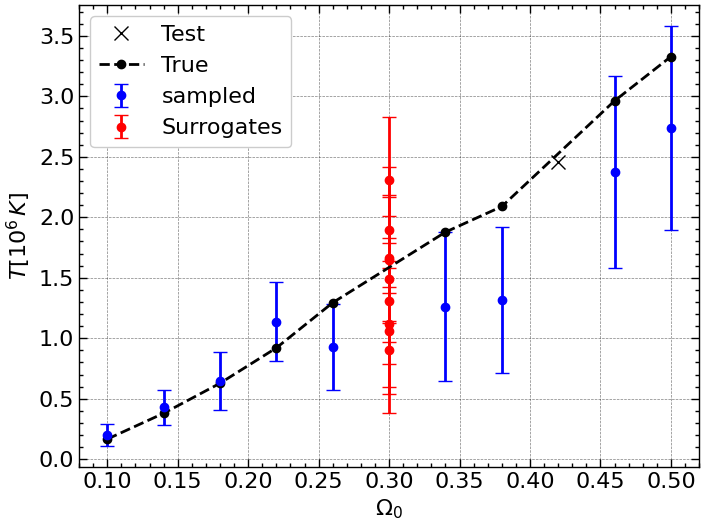

In [8]:
plt.errorbar(HR.params, HR.samples, yerr=np.sqrt(HR.var), fmt='o', capsize=5, label='sampled', c='blue')
plt.errorbar(Sur.params, Sur.surrogates, yerr=np.sqrt(Sur.var), fmt='o', capsize=5, label='Surrogates', c='red')
plt.plot(test.params, test.mean(), 'x', markersize=10, c='k', label='Test')
plt.plot(HR.params, HR.mean(), 'o--', label='True', c='k', lw=2)
plt.legend()
plt.ylabel('$T [10^6\,K]$')
plt.xlabel('$\Omega_0$')


In [9]:
SIM, CP, GP = comparison_driver(theta='s8', quantity='Ts', test_axis=9, 
                                surrogate_axis=[5], seed=193, pred_mean=True)#, paramsQ=CP.paramsQ, paramsR=CP.paramsR)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

/var/folders/2g/q1nb_42x629bp1zbjggj3xkw0000gp/T/ipykernel_46868/1917638920.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(CP.noise))


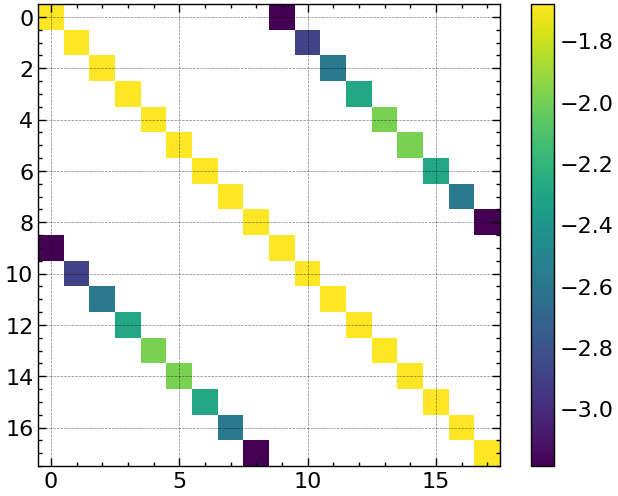

In [66]:
plt.imshow(np.log(CP.noise))
plt.colorbar()

Text(0, 0.5, '$T [10^6\\,K]$')

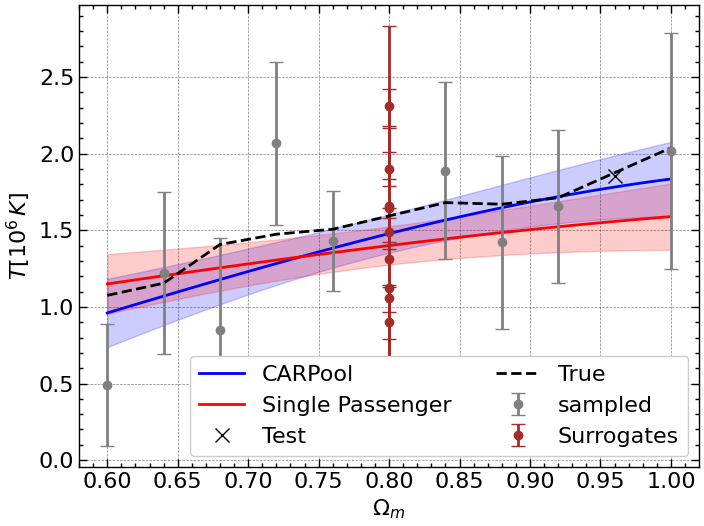

In [67]:
plt.plot(SIM.test.tests, CP.pred_range[0], 'b', label='CARPool')
plt.plot(SIM.test.tests, GP.pred_range[0], 'r', label='Single Passenger')

plt.fill_between(SIM.test.tests, CP.pred_range[0] - np.sqrt(np.diag(CP.pred_range[1])), CP.pred_range[0] + np.sqrt(np.diag(CP.pred_range[1])), color='b', alpha=0.2)
plt.fill_between(SIM.test.tests, GP.pred_range[0] - np.sqrt(np.diag(GP.pred_range[1])), GP.pred_range[0] + np.sqrt(np.diag(GP.pred_range[1])), color='r', alpha=0.2)



plt.errorbar(SIM.HR.params, SIM.HR.samples, yerr=np.sqrt(SIM.HR.var), fmt='o', capsize=5, label='sampled', c='grey')
plt.errorbar(SIM.Sur.params, SIM.Sur.surrogates, yerr=np.sqrt(SIM.Sur.var), fmt='o', capsize=5, label='Surrogates', c='brown')
plt.plot(SIM.test.params, SIM.test.mean(), 'x', markersize=10, c='k', label='Test')
plt.plot(SIM.HR.params,   SIM.HR.mean(), label='True', c='k', ls='--', lw=2)
plt.legend(ncol=2)
plt.xlabel('$\Omega_m$')
plt.ylabel('$T [10^6\,K]$')

# Iteration over all parameters, all axes, multiple times

In [15]:
# Nsamples = 10
# param_names = list(super_dict.keys())
# axes = np.arange(11)
# surrogate_axis=[5]
# Q = 'Ts'

# test_preds    = np.zeros((len(param_names), 11, Nsamples, 2))
# test_preds_CP = np.zeros((len(param_names), 11, Nsamples, 2))
# test_pred_ranges    = np.zeros((len(param_names), 11, Nsamples, 100))
# test_pred_ranges_CP = np.zeros((len(param_names), 11, Nsamples, 100))
# test_pred_ranges_cov    = np.zeros((len(param_names), 11, Nsamples, 100, 100))
# test_pred_ranges_cov_CP = np.zeros((len(param_names), 11, Nsamples, 100, 100))
# test_true = np.zeros((len(param_names), 11, Nsamples))

# for i, param in tqdm(enumerate(param_names)):
#     for axis in axes:
#         if axis not in surrogate_axis:
#             for sample in range(Nsamples):
#                 print(param, axis, sample)
#                 seed = len(axes) * i + Nsamples * (i + axis) + sample

#                 SIM, CP, GP = comparison_driver(theta=param, quantity=Q, 
#                                                 test_axis=axis, 
#                                                 surrogate_axis=surrogate_axis, 
#                                                 seed=seed, pred_mean=True)

#                 test_preds[i, axis, sample]          = np.ravel(GP.pred)
#                 test_preds_CP[i, axis, sample]       = np.ravel(CP.pred)
#                 test_pred_ranges[i, axis, sample]    = np.ravel(GP.pred_range[0])
#                 test_pred_ranges_CP[i, axis, sample] = np.ravel(CP.pred_range[0])
#                 test_pred_ranges_cov[i, axis, sample]    = np.ravel(GP.pred_range[1]).reshape(100, 100)
#                 test_pred_ranges_cov_CP[i, axis, sample] = np.ravel(CP.pred_range[1]).reshape(100,100)
#                 test_true[i, axis, sample]           = np.ravel(SIM.test.mean())
#         else:
#             test_preds[i, axis, sample]          = [0,0]
#             test_preds_CP[i, axis, sample]       = [0,0]
#             test_pred_ranges[i, axis, sample]    = np.zeros(100)
#             test_pred_ranges_cov[i, axis, sample]    = np.zeros((100, 100))
#             test_pred_ranges_cov_CP[i, axis, sample] = np.zeros((100, 100))
#             test_pred_ranges_CP[i, axis, sample] = np.zeros(100)
#             test_true[i, axis, sample]           = 0


In [138]:
# np.savez('Data/1P-test_Surrogate5', pred=test_preds, pred_CP=test_preds_CP, 
#         pred_range=test_pred_ranges, pred_range_CP=test_pred_ranges_CP, 
#         pred_range_cov=test_pred_ranges_cov, pred_range_cov_CP=test_pred_ranges_cov_CP, 
#         true=test_true)

In [18]:
f = np.load('Data/1P-test_Surrogate5.npz')
f.files

['pred',
 'pred_CP',
 'pred_range',
 'pred_range_CP',
 'pred_range_cov',
 'pred_range_cov_CP',
 'true']

In [20]:
pred = f['pred']
pred_CP=f['pred_CP']
true = f['true']

/var/folders/2g/q1nb_42x629bp1zbjggj3xkw0000gp/T/ipykernel_46868/3465945792.py:14: RuntimeWarning: divide by zero encountered in divide
  c2 = (np.mean(pred[i, :, :, 0], axis=-1) - true[i,j, 0])**2/np.std(pred[i, :, :, 0], axis=-1)
/var/folders/2g/q1nb_42x629bp1zbjggj3xkw0000gp/T/ipykernel_46868/3465945792.py:16: RuntimeWarning: divide by zero encountered in divide
  c2 = (np.mean(pred_CP[i, :, :, 0], axis=-1) - true[i,j, 0])**2/np.std(pred_CP[i, :, :, 0], axis=-1)


GP: 325.91492588091273
CP: 529.028416003557
GP: 23.524484458021067
CP: 34.65960758411074
GP: 4.781786967103248
CP: 7.395434819026712
GP: 1.4649492039384022
CP: 5.413004062578049
GP: 5.174243909337866
CP: 11.809066339612535
GP: 3.6005754885609287
CP: 9.42932666077467


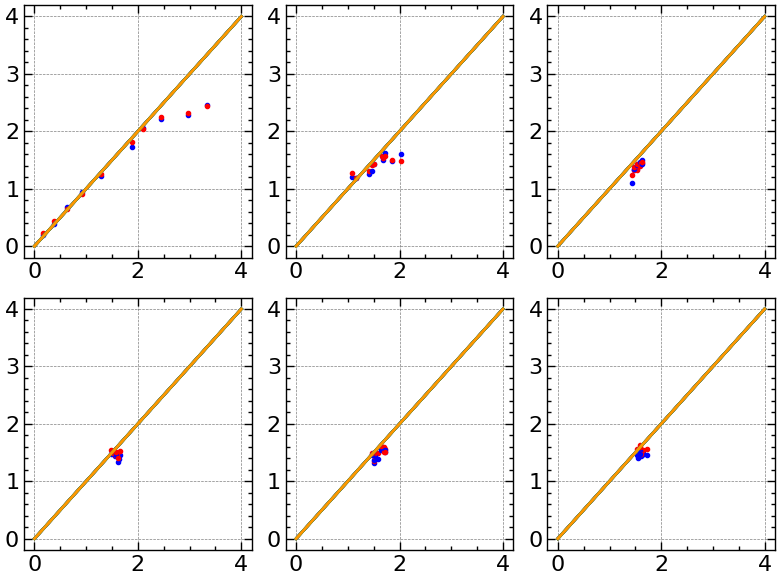

In [23]:
fig, axs = plt.subplots(ncols=3, nrows=2, sharex=False, sharey=False)

for i in range(6):
    for j in range(11):
        gps = []
        cps = []
        if j !=5:
            GP = np.mean(pred[i, j, :, 0])
            CP = np.mean(pred_CP[i, j, :, 0])
            T = true[i,j, 0]
            axs[i//3, i%3].plot(T, CP, 'b.')
            axs[i//3, i%3].plot(T, GP, 'r.')
            axs[i//3, i%3].plot(np.arange(5), np.arange(5))
    c2 = (np.mean(pred[i, :, :, 0], axis=-1) - true[i,j, 0])**2/np.std(pred[i, :, :, 0], axis=-1)
    print('GP:', np.sum(c2[~np.isinf(c2)]))
    c2 = (np.mean(pred_CP[i, :, :, 0], axis=-1) - true[i,j, 0])**2/np.std(pred_CP[i, :, :, 0], axis=-1)
    print('CP:', np.sum(c2[~np.isinf(c2)]))
        
plt.tight_layout()

In [46]:
pred_CP.shape

(6, 11, 10, 2)

In [48]:
def chi2(pred, val, err):
    return np.sum((pred - val)**2/err)

In [56]:
Qmeans = []
for name in list(param_df.columns)[1:-1]:
    quantity = 'Ts'
    Q = 1e-6*np.array(super_dict[name][quantity])[:, -20:]
#     Q = np.array(super_dict[theta][quantity])[:, :]
#     Q_mean = np.mean(np.delete(Q, 5, axis=0), axis=-1)

    Qmeans.append(Q.mean(axis=-1))
Qmeans=np.array(Qmeans)

In [59]:
np.shape(infile['pred_range_CP'])

(6, 11, 10, 100)

/var/folders/2g/q1nb_42x629bp1zbjggj3xkw0000gp/T/ipykernel_46868/4100468999.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.sum((pred - val)**2/err)


Text(0, 0.5, '$T$ [$10^6\\,K$]')

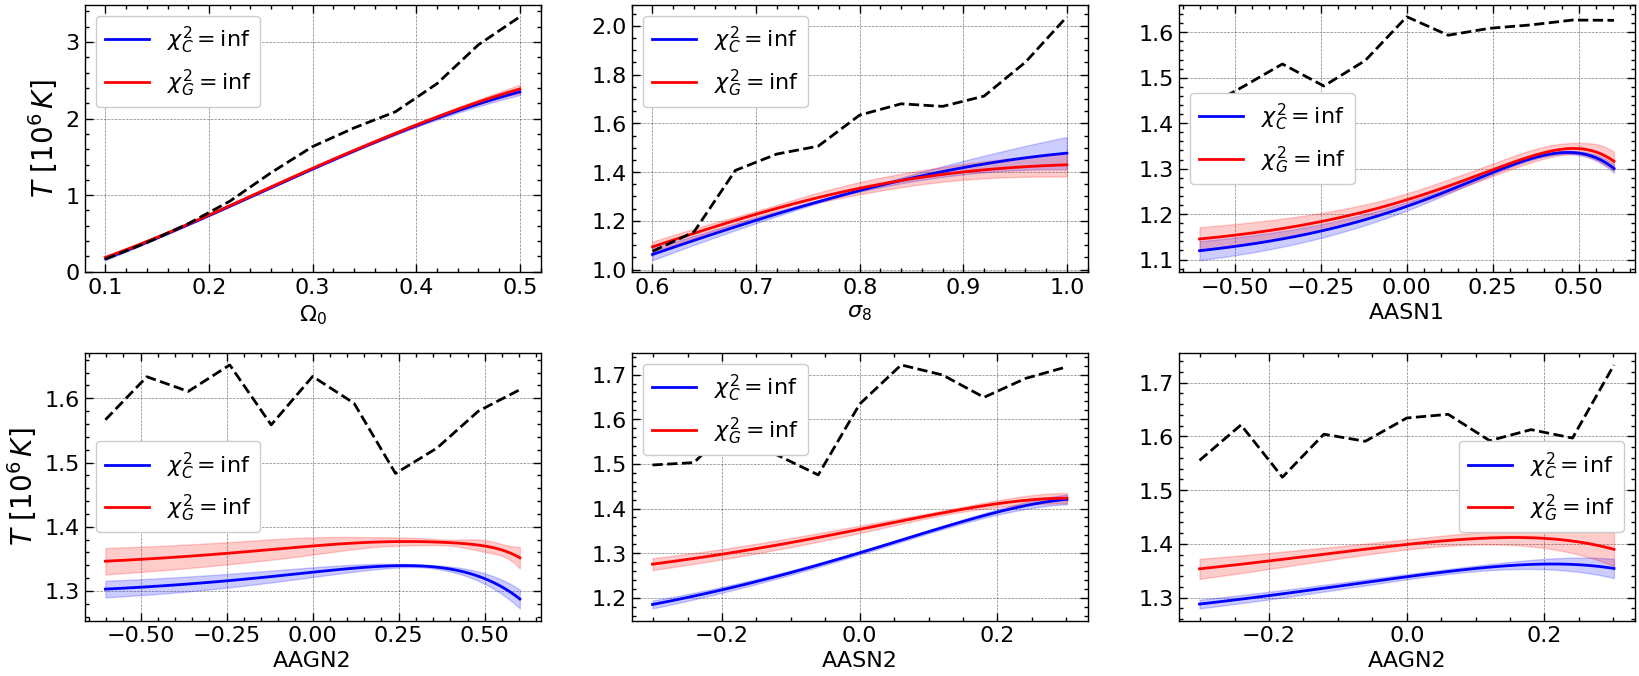

In [64]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20, 8), sharex=False, sharey=False, gridspec_kw={'hspace':0.3})
prof_names = [r'$\Omega_0$', r'$\sigma_8$', r'AASN1', 'AAGN2', 'AASN2', 'AAGN2']

for i, name in enumerate(list(param_df.columns)[1:-1]):
    infile = np.load('Data/1P-test_Surrogate5.npz')
    params = np.unique(param_df[name])
#     params = np.delete(params, 5)
    t = Test(params[1], Q[1], params.min(), params.max())
    tests = t.tests
    if i>1:
        params = np.log10(params)
        tests = np.log10(t.tests)
    if i ==0:
        m_c = infile['pred_CP'][i, :, :, 0].mean(axis=-1)
        m_g = infile['pred'][i, :, :, 0].mean(axis=-1)
        s_c = infile['pred_CP'][i, :, :, 0].var(axis=-1)
        s_g = infile['pred'][i, :, :, 0].var(axis=-1)
        c2_c = round(chi2(Qmeans[i], m_c, s_c), 3)
        c2_g = round(chi2(Qmeans[i], m_g, s_g), 3)

        m_c = infile['pred_range_CP'][i].mean(axis=0).mean(axis=0)
        m_g = infile['pred_range'][i].mean(axis=0).mean(axis=0)
        s_c = infile['pred_range_CP'][i].std(axis=0).std(axis=0)
        s_g = infile['pred_range'][i].std(axis=0).std(axis=0)
#         c2_c = round(chi2(Qmeans[i], dc.mean(axis=-1),dc.std(axis=-1)), 3)

#         axs[i//3, i%3].plot(params, m_c, '-', markersize=10, label='CARPool', c='b')
#         axs[i//3, i%3].fill_between(params, m_c+s_c, m_c-s_c, color='b', alpha=0.2)
#         axs[i//3, i%3].plot(params, m_g, '-', markersize=10, label='Single Passenger', c='r')
#         axs[i//3, i%3].fill_between(params, m_g+s_g, m_g-s_g, color='r', alpha=0.2)
#         axs[i//3, i%3].plot(params, Qmeans[i], c='k', lw=2, ls='--')
        
        axs[i//3, i%3].plot(tests, m_c, '-', markersize=10, label=r'$\chi^2_{C}=$' + f'{c2_c}', c='b')
        axs[i//3, i%3].fill_between(tests, m_c+s_c, m_c-s_c, color='b', alpha=0.2)
        axs[i//3, i%3].plot(tests, m_g, '-', markersize=10, label=r'$\chi^2_{G}=$' + f'{c2_g}', c='r')
        axs[i//3, i%3].fill_between(tests, m_g+s_g, m_g-s_g, color='r', alpha=0.2)
        axs[i//3, i%3].plot(params, Qmeans[i], c='k', lw=2, ls='--')
    else:
        m_c = infile['pred_CP'][i, :, :, 0].mean(axis=-1)
        m_g = infile['pred'][i, :, :, 0].mean(axis=-1)
        s_c = infile['pred_CP'][i, :, :, 0].var(axis=-1)
        s_g = infile['pred'][i, :, :, 0].var(axis=-1)
        c2_c = round(chi2(Qmeans[i], m_c, s_c), 3)
        c2_g = round(chi2(Qmeans[i], m_g, s_g), 3)

        m_c = infile['pred_range_CP'][i].mean(axis=0).mean(axis=0)
        m_g = infile['pred_range'][i].mean(axis=0).mean(axis=0)
        s_c = infile['pred_range_CP'][i].std(axis=0).std(axis=0)
        s_g = infile['pred_range'][i].std(axis=0).std(axis=0)
#         axs[i//3, i%3].plot(params, m_c, '-', markersize=10, label='CARPool', c='b')
#         axs[i//3, i%3].fill_between(params, m_c+s_c, m_c-s_c, color='b', alpha=0.2)
#         axs[i//3, i%3].plot(params, m_g, '-', markersize=10, label='Single Passenger', c='r')
#         axs[i//3, i%3].fill_between(params, m_g+s_g, m_g-s_g, color='r', alpha=0.2)
#         axs[i//3, i%3].plot(params, Qmeans[i], c='k', lw=2, ls='--')
        
        axs[i//3, i%3].plot(tests, m_c, '-', markersize=10, label=r'$\chi^2_{C}=$' + f'{c2_c}', c='b')
        axs[i//3, i%3].fill_between(tests, m_c+s_c, m_c-s_c, color='b', alpha=0.2)
        axs[i//3, i%3].plot(tests, m_g, '-', markersize=10, label=r'$\chi^2_{G}=$' + f'{c2_g}', c='r')
        axs[i//3, i%3].fill_between(tests, m_g+s_g, m_g-s_g, color='r', alpha=0.2)
        axs[i//3, i%3].plot(params, Qmeans[i], c='k', lw=2, ls='--')
        axs[i//3, i%3].legend()
        
    axs[i//3, i%3].set_xlabel(prof_names[i])
#     axs[i//3, i%3].axhline(0, color='k')
axs[0,0].legend()
axs[0, 0].set_ylabel(r'$T$ [$10^6\,K$]', fontsize=20)
axs[1, 0].set_ylabel(r'$T$ [$10^6\,K$]', fontsize=20)
#     axs[i//3, i%3].plot(np.linspace(Qmeans[i].min(), Qmeans[i].max(), 1000), np.linspace(Qmeans[i].min(), Qmeans[i].max(), 1000))